## Modeling strategy:
* Given the limited sample size, I will compare a set of reduced features chosen based on interpretability and compare to models utilizing the principal components of the full set of features.
* Will compare the prediction of OLS, Ridge and Lasso regression.  The optimal value of lambda for Ridge and Lasso will be determined iteratively using GridSearch.
* Models with first and second order polynomials will be assesed.
* A 20% train-test split will be used to cross validate the models using the RMSE and adjusted R-squared as evaluation metrics.  RMSE is preferred to MSE as it's in the original units (£).

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import seaborn as sns
import py_files.custom_functions as cf

In [2]:
#Importing dataframe
df = pd.read_csv('data/df_with_engineered_features.csv')

In [3]:
#Creating dummy variables for modeling
df['attacker'] = df['position_agg'].map(lambda x: 1 if x =='attacker' else 0)
df['defender'] = df['position_agg'].map(lambda x: 1 if x =='defender' else 0)
df['midfielder'] = df['position_agg'].map(lambda x: 1 if x =='midfielder' else 0)

In [4]:
y = df['fee_final_logged']
#First draft model - limited to basic demographics and statistics
#age, nationality 
#number of starts, position
#Goals, assists, completed passes, blocks, clearances and interceptions (3 most important offensive and defensive stats)

reduced = ['age_y', 'French','Spain', 'Italy', 'Germany', 'Brazil', 'England', 'Argentina', 'other_euro',
             'other_SA', 'Concacaf', 'oceanian', 'CAF',
             'games_start','attacker','midfielder',
             'goals', 'assists','passes_completed','blocks','clearances','interceptions']
X_reduced = df[reduced]

In [5]:
#Train-test split 
X_red_train, X_red_test, y_train, y_test = train_test_split(X_reduced, y, random_state=9,test_size=0.2)

In [6]:
# Using standard scaler on features (regularization is based on the magnitude of the 
# coefficient)

ss = StandardScaler()
X_red_train_ss = ss.fit_transform(X_red_train)
X_red_test_ss = ss.transform(X_red_test)

## First order polynomials:
* Linear regression
* GridSearch Ridge
* GridSearch Lasso

### OLS regression

In [7]:
#instantiate a linear regression object
lm = LinearRegression()

#fit the linear regression to the data
lm = lm.fit(X_red_train_ss, y_train)

In [8]:
#model_evaluation is a custom function I built - 
#     takes as an arugment a model that has already
#     been fit (to accomodate difference in fitting of OLS and gridsearching
#     ridge and lasso).  Note that should be fed the fit linear model or the 
#     appropriate "model.best_estimator_" for grid searched models.  Additionally
#     takes in the train and test X and y df/series to facilitate use with polynomials
#     and PCA.  
#     Returns the train and test adjusted R^2 and RMSE in original units
cf.model_evaluation(lm, X_red_train_ss,X_red_test_ss, y_train, y_test)

Model eval for: LinearRegression()
Training adj R squared: 0.31
Training Root Mean Squared Error: 11180629.076
Testing adj R squared: 0.127
Testing Root Mean Squared Error: 18079019.443


### Interpretation:
* Baseline model
* Train RMSE is > 11 million pounds and adjusted r square is 31% suggesting not a great fit (overall mean transfer fee = £11,944,740).
* Test RMSE is 7 million pounds higher than training RMSE suggesting we have overfit to the training data.
* Test adj r-square is only 12.7% suggesting only small explanatory power.

* Next steps - regularization may perform feature selection to remove unimportant features 

### Grid searching lambda for ridge
* iterating through values of lambda (alpha) to find the best estimate

In [9]:
ridge_params = {'alpha':[0.001,0.01,.5,1,5,10]}
ridge = Ridge()
grid_ridge = GridSearchCV(estimator=ridge, param_grid=ridge_params)
grid_ridge.fit(X_red_train_ss, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.5, 1, 5, 10]})

In [10]:
grid_ridge.best_estimator_

Ridge(alpha=10)

In [11]:
ridge_params2 = {'alpha':[8,10,12,16,20,25]}
ridge = Ridge()
grid_ridge2 = GridSearchCV(estimator=ridge, param_grid=ridge_params2)
grid_ridge2.fit(X_red_train_ss, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [8, 10, 12, 16, 20, 25]})

In [12]:
grid_ridge2.best_estimator_

Ridge(alpha=25)

In [13]:
ridge_params3 = {'alpha':[25,100,1000,10000000]}
ridge = Ridge()
grid_ridge3 = GridSearchCV(estimator=ridge, param_grid=ridge_params3)
grid_ridge3.fit(X_red_train_ss, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [25, 100, 1000, 10000000]})

In [14]:
grid_ridge3.best_estimator_

Ridge(alpha=25)

In [15]:
ridge_params4 = {'alpha':[22,25,27,30,35]}
ridge = Ridge()
grid_ridge4 = GridSearchCV(estimator=ridge, param_grid=ridge_params4)
grid_ridge4.fit(X_red_train_ss, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [22, 25, 27, 30, 35]})

In [16]:
grid_ridge4.best_estimator_

Ridge(alpha=27)

In [17]:
cf.model_evaluation(grid_ridge4.best_estimator_, X_red_train_ss,X_red_test_ss, y_train, y_test)

Model eval for: Ridge(alpha=27)
Training adj R squared: 0.306
Training Root Mean Squared Error: 11380364.041
Testing adj R squared: 0.138
Testing Root Mean Squared Error: 17988762.121


### Interpretation:
* Ridge model - fit statistics are very similar to the OLS model

* Next steps - Lasso may fully remove unnecessary coefficients

### Grid Searching lambda for Lasso
* iterating through values of lambda (alpha) to find the best estimate

In [18]:
lasso_params = {'alpha':[0.001,0.01,.5,1,5,10]}
lasso = Lasso()
grid_lasso = GridSearchCV(estimator=lasso, param_grid=lasso_params)
grid_lasso.fit(X_red_train_ss, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 0.5, 1, 5, 10]})

In [19]:
grid_lasso.best_estimator_

Lasso(alpha=0.01)

In [20]:
lasso_params2 = {'alpha':[0.003,0.007,0.01,.03,0.07]}
lasso = Lasso()
grid_lasso2 = GridSearchCV(estimator=lasso, param_grid=lasso_params2)
grid_lasso2.fit(X_red_train_ss, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.003, 0.007, 0.01, 0.03, 0.07]})

In [21]:
grid_lasso2.best_estimator_

Lasso(alpha=0.007)

In [22]:
cf.model_evaluation(grid_lasso2.best_estimator_, X_red_train_ss,X_red_test_ss, y_train, y_test)

Model eval for: Lasso(alpha=0.007)
Training adj R squared: 0.308
Training Root Mean Squared Error: 11261098.835
Testing adj R squared: 0.144
Testing Root Mean Squared Error: 17947248.468


## Interpretation:
* Lasso model - RMSE is very similar to Ridge regression.  Slight increase in adjusted r-square.  Likely due to censoring of coefficients reducing the complexity.

## Second order polynomials
* Assessing to see if incorporating interactions and second order polynomials improves the fit of the models

In [23]:
#Instantiating a polynomial featuers object
poly2 = PolynomialFeatures(degree=2)

#Fitting/transforming poly features object to the data
poly2_data = poly2.fit_transform(X_reduced)

#Creating a df of the poly features
poly2_columns = poly2.get_feature_names(X_reduced.columns)
X_reduced_poly = pd.DataFrame(poly2_data, columns=poly2_columns)
X_reduced_poly.head()

,1,age_y,French,Spain,Italy,Germany,Brazil,England,Argentina,other_euro,...,passes_completed^2,passes_completed blocks,passes_completed clearances,passes_completed interceptions,blocks^2,blocks clearances,blocks interceptions,clearances^2,clearances interceptions,interceptions^2
0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,458329.0,19633.0,7447.0,10155.0,841.0,319.0,435.0,121.0,165.0,225.0
1,1.0,19.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,22201.0,1490.0,745.0,298.0,100.0,50.0,20.0,25.0,10.0,4.0
2,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,263169.0,15390.0,22059.0,8208.0,900.0,1290.0,480.0,1849.0,688.0,256.0
3,1.0,26.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1121481.0,44478.0,5295.0,16944.0,1764.0,210.0,672.0,25.0,80.0,256.0
4,1.0,22.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,988036.0,23856.0,16898.0,21868.0,576.0,408.0,528.0,289.0,374.0,484.0


In [24]:
#train test split
X_red_poly2_train, X_red_poly2_test, y_train, y_test = train_test_split(X_reduced_poly, y, random_state=9, test_size=0.2)

In [25]:
# Standard scaler for features
ss_poly = StandardScaler()
X_red_poly2_train_ss = ss_poly.fit_transform(X_red_poly2_train)
X_red_poly2_test_ss = ss_poly.transform(X_red_poly2_test)

### OLS

In [26]:
#instantiate a linear regression object
lm_poly = LinearRegression()

#fit the linear regression to the data
lm_poly = lm_poly.fit(X_red_poly2_train_ss, y_train)

In [27]:
cf.model_evaluation(lm_poly, X_red_poly2_train_ss, X_red_poly2_test_ss, y_train, y_test)

Model eval for: LinearRegression()
Training adj R squared: 0.474
Training Root Mean Squared Error: 13543810.282
Testing adj R squared: -3.9627525696792263e+24
Testing Root Mean Squared Error: 616948549.737


### Interpretation:
* The training adj R square and RMSE have improved but as we can see from the values from the test set we have dramatically overfit the model. 
* A negative value of the adjusted r-square indicates that we have added too many variables while extracting too little information.

* Next steps - assess whether regularization can reduce the complexity leaving only important features.

### Ridge regression

In [28]:
ridge_poly2_params = {'alpha':[0.001,0.01,.5,1,5,10]}
ridge_poly2 = Ridge()
grid_poly2_ridge = GridSearchCV(estimator=ridge_poly2, param_grid=ridge_poly2_params)
grid_poly2_ridge.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.5, 1, 5, 10]})

In [29]:
grid_poly2_ridge.best_estimator_

Ridge(alpha=10)

In [30]:
ridge_poly2_params2 = {'alpha':[10,15,20,25,30,35,40]}
ridge_poly2 = Ridge()
grid_poly2_ridge2 = GridSearchCV(estimator=ridge_poly2, param_grid=ridge_poly2_params2)
grid_poly2_ridge2.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [10, 15, 20, 25, 30, 35, 40]})

In [31]:
grid_poly2_ridge2.best_estimator_

Ridge(alpha=40)

In [32]:
ridge_poly2_params3 = {'alpha':[40,50,60,70,80,90,100]}
ridge_poly2 = Ridge()
grid_poly2_ridge3 = GridSearchCV(estimator=ridge_poly2, param_grid=ridge_poly2_params3)
grid_poly2_ridge3.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [40, 50, 60, 70, 80, 90, 100]})

In [33]:
grid_poly2_ridge3.best_estimator_

Ridge(alpha=100)

In [34]:
ridge_poly2_params4 = {'alpha':[100,150,200,250,300]}
ridge_poly2 = Ridge()
grid_poly2_ridge4 = GridSearchCV(estimator=ridge_poly2, param_grid=ridge_poly2_params4)
grid_poly2_ridge4.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Ridge(), param_grid={'alpha': [100, 150, 200, 250, 300]})

In [35]:
grid_poly2_ridge4.best_estimator_

Ridge(alpha=300)

In [36]:
ridge_poly2_params5 = {'alpha':[270,290,300,310,330,340,350]}
ridge_poly2 = Ridge()
grid_poly2_ridge5 = GridSearchCV(estimator=ridge_poly2, param_grid=ridge_poly2_params5)
grid_poly2_ridge5.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [270, 290, 300, 310, 330, 340, 350]})

In [37]:
grid_poly2_ridge5.best_estimator_

Ridge(alpha=330)

In [38]:
cf.model_evaluation(grid_poly2_ridge5.best_estimator_, X_red_poly2_train_ss, X_red_poly2_test_ss, y_train,y_test)

Model eval for: Ridge(alpha=330)
Training adj R squared: 0.365
Training Root Mean Squared Error: 10808971.514
Testing adj R squared: 0.14
Testing Root Mean Squared Error: 18016336.391


### Interpretation:
* Fit statistics on the training set are worse for this model compared to the OLS model but are slightly better than the models with the first order polynomials.
* Still an average error on unseen data of > £18 million

## Grid search for lasso lambda

In [39]:
lasso_poly2_params = {'alpha':[0.001,0.01,.5,1,5,10]}
lasso_poly2 = Lasso(max_iter=7000)
grid_poly2_lasso = GridSearchCV(estimator=lasso_poly2, param_grid=lasso_poly2_params)
grid_poly2_lasso.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Lasso(max_iter=7000),
             param_grid={'alpha': [0.001, 0.01, 0.5, 1, 5, 10]})

In [40]:
grid_poly2_lasso.best_estimator_

Lasso(alpha=0.01, max_iter=7000)

In [41]:
lasso_poly2_params2 = {'alpha':[0.003,0.007,0.01,.03,0.07]}
lasso_poly2 = Lasso(max_iter=7000)
grid_poly2_lasso2 = GridSearchCV(estimator=lasso_poly2, param_grid=lasso_poly2_params2)
grid_poly2_lasso2.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Lasso(max_iter=7000),
             param_grid={'alpha': [0.003, 0.007, 0.01, 0.03, 0.07]})

In [42]:
grid_poly2_lasso2.best_estimator_

Lasso(alpha=0.07, max_iter=7000)

In [43]:
lasso_poly2_params3 = {'alpha':[0.05,0.07,0.09,0.11,0.15,0.2,0.3,0.4]}
lasso_poly2 = Lasso(max_iter=7000)
grid_poly2_lasso3 = GridSearchCV(estimator=lasso_poly2, param_grid=lasso_poly2_params3)
grid_poly2_lasso3.fit(X_red_poly2_train_ss, y_train)

GridSearchCV(estimator=Lasso(max_iter=7000),
             param_grid={'alpha': [0.05, 0.07, 0.09, 0.11, 0.15, 0.2, 0.3,
                                   0.4]})

In [44]:
grid_poly2_lasso3.best_estimator_

Lasso(alpha=0.05, max_iter=7000)

In [45]:
cf.model_evaluation(grid_poly2_lasso3.best_estimator_,X_red_poly2_train_ss, X_red_poly2_test_ss, y_train,y_test)

Model eval for: Lasso(alpha=0.05, max_iter=7000)
Training adj R squared: 0.307
Training Root Mean Squared Error: 11727801.247
Testing adj R squared: 0.167
Testing Root Mean Squared Error: 18144495.021


### Interpretation:
* Testing RMSE is similar to the value for ridge regression but similar to first order polynomials we see an improvement in the adjusted r-square likely due to the feature selection inherent in LASSO.

# PCA
* Previous models included features selected based on domain knowledge
* Rather than rely on selected variables extract the most informative principal components and model following a similar logic to the above

In [46]:
#import PCA
from sklearn.decomposition import PCA

In [47]:
#list of all features
features = ['age_y', 'games', 'games_start', 'goals', 'assists','pens_successful',
          'pens_attempts', 'yellow_cards', 'red_cards', 'xg', 'npxp', 'xa', 'full_90s_played',
          'shots_total', 'shots_on_target', 'npxg','passes_completed','passes_attempted',
          'passes_total_dist','passes_prog_dist','passes_completed_short', 'passes_attempted_short',
          'passes_completed_medium','passes_attempted_medium','passes_completed_long', 'passes_attempted_long', 
          'xa_net', 'assisted_shots', 'passes_into_final_third', 'passes_into_penalty_area', 'crosses_into_penalty_area',
          'progressive_passes','sca','sca_passes_live','sca_passes_dead','sca_dribbles','sca_shots','sca_fouled',
 'sca_defense', 'gca', 'gca_passes_live', 'gca_passes_dead', 'gca_dribbles', 'gca_shots', 'gca_fouled',
 'gca_defense', 'gca_og_for', 'tackles', 'tackles_won', 'tackles_def_3rd', 'tackles_mid_3rd', 'tackles_att_3rd',
 'dribble_tackles', 'dribble_vs', 'dribbled_past', 'pressures', 'pressure_regains', 'pressures_def_3rd',
 'pressures_mid_3rd', 'pressures_att_3rd', 'blocks', 'blocked_shots', 'blocked_shots_saves',
 'blocked_passes', 'interceptions', 'tackles_interceptions', 'clearances', 'errors', 'touches',
 'touches_def_pen_area', 'touches_def_3rd', 'touches_mid_3rd', 'touches_att_3rd', 'touches_att_pen_area',
 'touches_live_ball', 'dribbles_completed', 'dribbles', 'players_dribbled_past', 'nutmegs',
 'carries', 'carry_distance','carry_progressive_distance', 'pass_targets', 'passes_received', 'miscontrols',
 'dispossessed', 'passes_left_foot', 'passes_right_foot', 'aerials_won', 'aerials_lost', 'mins_num',
  'attacker','defender','midfielder',
 'French', 'Spain', 'Italy', 'Germany', 'Brazil', 'England', 'Argentina', 'other_euro', 'other_SA', 'Concacaf',
 'oceanian', 'CAF',
  'selling_club_mega', 'buying_club_mega',
 ]

In [48]:
#create x and y dfs
y_pca = df['fee_final_logged']
x_pca = df[features]

In [49]:
#train-test split
X_pca_train, X_pca_test, y_pca_train, y_pca_test = train_test_split(x_pca, y_pca, random_state=9,test_size=0.2)

In [50]:
#Standardizing before fitting the PCA to give all variables equal weight 
ss_pca = StandardScaler()
X_pca_train_ss = ss_pca.fit_transform(X_pca_train)
X_pca_test_ss = ss_pca.transform(X_pca_test)

In [51]:
#Fitting the PCA to the data
pca = PCA()
pca_train = pca.fit_transform(X_pca_train_ss)
pca_test = pca.transform(X_pca_test_ss)

In [52]:
#Checking the % variance explained by each principle component
pca.explained_variance_ratio_

array([3.46458254e-01, 1.80802578e-01, 5.26521101e-02, 4.16907414e-02,
       2.57098421e-02, 2.02437879e-02, 1.53712495e-02, 1.51213762e-02,
       1.48795525e-02, 1.30925781e-02, 1.27285423e-02, 1.24145507e-02,
       1.13460167e-02, 1.10352979e-02, 1.10150856e-02, 1.06840669e-02,
       1.03446197e-02, 1.02709171e-02, 9.85998971e-03, 9.64477967e-03,
       9.43724050e-03, 8.77939702e-03, 8.58687921e-03, 8.22991609e-03,
       7.77539202e-03, 7.63403763e-03, 7.50294110e-03, 6.74503750e-03,
       6.45566782e-03, 6.36812828e-03, 6.22431335e-03, 6.07523218e-03,
       5.29731568e-03, 5.01519653e-03, 4.61123306e-03, 4.17834580e-03,
       3.97029862e-03, 3.81191731e-03, 3.58685065e-03, 3.36311581e-03,
       3.16848997e-03, 2.90281351e-03, 2.59112805e-03, 2.56987120e-03,
       2.27820976e-03, 2.05094420e-03, 1.95713186e-03, 1.88970037e-03,
       1.70040628e-03, 1.64482272e-03, 1.46127352e-03, 1.40245021e-03,
       1.26853753e-03, 1.21830836e-03, 1.12357251e-03, 1.04805662e-03,
      

### Scree Plot
* Extracting the first 6 components - all others explain less than 2% of the variance in the dataset

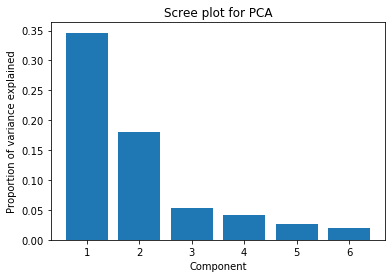

In [53]:
index = list(range(1,7))
plt.bar(index, pca.explained_variance_ratio_[0:6])
plt.title('Scree plot for PCA')
plt.ylabel('Proportion of variance explained')
plt.xlabel('Component')
plt.savefig('Images/scree_plot.png')

## Interpretation:
* First PC explains 34.6%
* Second PC explains 18.1%
* Third PC explains 5.3%
* Fourth PC explains 4.2% 
* Fifth PC explains 2.6%
* Sixth PC explains 2.0%
* Not a great proportion of the variance is explained by this extensive dataset.  Somewhat surprising given that many features are essentially interchangable.  Though this may also reflect the aggregation of attackers/defenders/midfielders as well as players at different stages of their career (and thus various statistical profiles) being transfered

In [54]:
#Checking the factor loadings
eig_values = pca.explained_variance_
pc1 = pca.components_[0]
pc2 = pca.components_[1]
pc3 = pca.components_[2]
pc4 = pca.components_[3]
pc5 = pca.components_[4]
pc6 = pca.components_[5]

In [55]:
#Getting factor loadings:
loading1 = pc1*np.sqrt(eig_values[0])
loading1_df = pd.Series(loading1, index=features)

loading2 = pc1*np.sqrt(eig_values[1])
loading2_df = pd.Series(loading2, index=features)

loading3 = pc1*np.sqrt(eig_values[2])
loading3_df = pd.Series(loading3, index=features)

loading4 = pc1*np.sqrt(eig_values[3])
loading4_df = pd.Series(loading4, index=features)

loading5 = pc1*np.sqrt(eig_values[4])
loading5_df = pd.Series(loading5, index=features)

loading6 = pc1*np.sqrt(eig_values[5])
loading6_df = pd.Series(loading6, index=features)

In [56]:
loading1_df.sort_values(ascending=False)

carries              0.942927
touches              0.937835
pass_targets         0.934726
touches_live_ball    0.930271
passes_received      0.927423
                       ...   
Italy               -0.050793
selling_club_mega   -0.051415
age_y               -0.075438
Concacaf            -0.102276
attacker            -0.159391
Length: 108, dtype: float64

## PC1 loadings:
* Variables loading above 0.9:
carries                       
touches                       
pass_targets                  
touches_live_ball             
passes_received               
mins_num                      
full_90s_played               
games_start                   
passes_attempted_short

* Carries/touches etc go hand in hand. Makes sense these would track together
* mins, full 90's played and starts are measures of playing time and certainly would be correlated.

In [57]:
pd.options.display.max_rows = 108
loading2_df.sort_values(ascending=False)

carries                       0.681169
touches                       0.677491
pass_targets                  0.675244
touches_live_ball             0.672027
passes_received               0.669969
mins_num                      0.663540
full_90s_played               0.663529
games_start                   0.661070
passes_attempted_short        0.651326
carry_distance                0.649753
passes_attempted              0.644774
touches_mid_3rd               0.642880
passes_completed_short        0.633339
progressive_passes            0.630480
games                         0.615347
carry_progressive_distance    0.612165
passes_completed              0.611443
pressure_regains              0.609650
pressures                     0.583593
sca_passes_live               0.577700
blocked_passes                0.573336
passes_attempted_medium       0.569395
passes_total_dist             0.564376
dribble_vs                    0.562286
sca                           0.561451
blocks                   

In [58]:
loading3_df.sort_values(ascending=False)

carries                       0.367587
touches                       0.365602
pass_targets                  0.364390
touches_live_ball             0.362654
passes_received               0.361543
mins_num                      0.358074
full_90s_played               0.358068
games_start                   0.356741
passes_attempted_short        0.351483
carry_distance                0.350634
passes_attempted              0.347947
touches_mid_3rd               0.346925
passes_completed_short        0.341776
progressive_passes            0.340233
games                         0.332067
carry_progressive_distance    0.330350
passes_completed              0.329960
pressure_regains              0.328992
pressures                     0.314931
sca_passes_live               0.311751
blocked_passes                0.309396
passes_attempted_medium       0.307269
passes_total_dist             0.304561
dribble_vs                    0.303433
sca                           0.302983
blocks                   

In [59]:
loading4_df.sort_values(ascending=False)

carries                       0.327094
touches                       0.325328
pass_targets                  0.324249
touches_live_ball             0.322704
passes_received               0.321716
mins_num                      0.318629
full_90s_played               0.318623
games_start                   0.317442
passes_attempted_short        0.312763
carry_distance                0.312008
passes_attempted              0.309617
touches_mid_3rd               0.308708
passes_completed_short        0.304126
progressive_passes            0.302753
games                         0.295487
carry_progressive_distance    0.293958
passes_completed              0.293612
pressure_regains              0.292751
pressures                     0.280238
sca_passes_live               0.277409
blocked_passes                0.275313
passes_attempted_medium       0.273420
passes_total_dist             0.271011
dribble_vs                    0.270007
sca                           0.269606
blocks                   

In [60]:
loading5_df.sort_values(ascending=False)

carries                       0.256864
touches                       0.255476
pass_targets                  0.254629
touches_live_ball             0.253416
passes_received               0.252640
mins_num                      0.250216
full_90s_played               0.250212
games_start                   0.249284
passes_attempted_short        0.245610
carry_distance                0.245017
passes_attempted              0.243139
touches_mid_3rd               0.242425
passes_completed_short        0.238827
progressive_passes            0.237749
games                         0.232043
carry_progressive_distance    0.230842
passes_completed              0.230570
pressure_regains              0.229894
pressures                     0.220068
sca_passes_live               0.217846
blocked_passes                0.216200
passes_attempted_medium       0.214714
passes_total_dist             0.212822
dribble_vs                    0.212034
sca                           0.211719
blocks                   

In [61]:
loading6_df.sort_values(ascending=False)

carries                       0.227929
touches                       0.226698
pass_targets                  0.225946
touches_live_ball             0.224869
passes_received               0.224181
mins_num                      0.222030
full_90s_played               0.222026
games_start                   0.221203
passes_attempted_short        0.217942
carry_distance                0.217416
passes_attempted              0.215750
touches_mid_3rd               0.215116
passes_completed_short        0.211924
progressive_passes            0.210967
games                         0.205904
carry_progressive_distance    0.204839
passes_completed              0.204597
pressure_regains              0.203997
pressures                     0.195278
sca_passes_live               0.193306
blocked_passes                0.191846
passes_attempted_medium       0.190527
passes_total_dist             0.188848
dribble_vs                    0.188149
sca                           0.187869
blocks                   

## Interpretation:
* The order of the features is the same for all 6 PCs but the loadings get progressively lower.  
* Seems to be in order of the variables with the largest range of values.

## Modeling the PCs

In [62]:
#making train and test df of the first 6 principal components
pca_train_6 = pca_train[:,0:6]
pca_test_6 = pca_test[:,0:6]

### OLS regression

In [63]:
lm_pca = LinearRegression()
lm_pca = lm_pca.fit(pca_train_6, y_train)
cf.model_evaluation(lm_pca, pca_train_6,pca_test_6, y_train, y_test)

Model eval for: LinearRegression()
Training adj R squared: 0.25
Training Root Mean Squared Error: 14494782.407
Testing adj R squared: 0.227
Testing Root Mean Squared Error: 17085176.007


### Interpretation:
* Lowest test RMSE and highest test adj R-square yet.
* Absolute value of RMSE still large

### Ridge Regression

In [64]:
ridge_params_pca = {'alpha':[0.001,0.01,.5,1,5,10]}
ridge_pca = Ridge()
grid_ridge_pca = GridSearchCV(estimator=ridge_pca, param_grid=ridge_params_pca)
grid_ridge_pca.fit(pca_train_6, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [0.001, 0.01, 0.5, 1, 5, 10]})

In [65]:
grid_ridge_pca.best_estimator_

Ridge(alpha=10)

In [66]:
ridge_params_pca2 = {'alpha':[10,20,30,40,50,60,70,80,90,100]}
ridge_pca = Ridge()
grid_ridge_pca2 = GridSearchCV(estimator=ridge_pca, param_grid=ridge_params_pca2)
grid_ridge_pca2.fit(pca_train_6, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]})

In [67]:
grid_ridge_pca2.best_estimator_

Ridge(alpha=100)

In [68]:
ridge_params_pca3 = {'alpha':[100,150,200,250,300,350,500]}
ridge_pca = Ridge()
grid_ridge_pca3 = GridSearchCV(estimator=ridge_pca, param_grid=ridge_params_pca3)
grid_ridge_pca3.fit(pca_train_6, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [100, 150, 200, 250, 300, 350, 500]})

In [69]:
grid_ridge_pca3.best_estimator_

Ridge(alpha=100)

In [70]:
ridge_params_pca4 = {'alpha':[95,97,100,105,110,115,120,125]}
ridge_pca = Ridge()
grid_ridge_pca4 = GridSearchCV(estimator=ridge_pca, param_grid=ridge_params_pca4)
grid_ridge_pca4.fit(pca_train_6, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [95, 97, 100, 105, 110, 115, 120, 125]})

In [71]:
grid_ridge_pca4.best_estimator_

Ridge(alpha=100)

In [72]:
cf.model_evaluation(grid_ridge_pca4.best_estimator_,pca_train_6,pca_test_6, y_train, y_test)

Model eval for: Ridge(alpha=100)
Training adj R squared: 0.249
Training Root Mean Squared Error: 13620290.547
Testing adj R squared: 0.228
Testing Root Mean Squared Error: 17167525.836


### Interpretation:
* Not much difference between OLS and Ridge fit statistics
    * only 6 features

### Lasso regression

In [73]:
lasso_params_pca = {'alpha':[0.001,0.01,1,10,50,100]}
lasso_pca = Lasso()
grid_lasso_pca = GridSearchCV(estimator=lasso_pca, param_grid=lasso_params_pca)
grid_lasso_pca.fit(pca_train_6, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.001, 0.01, 1, 10, 50, 100]})

In [74]:
grid_lasso_pca.best_estimator_

Lasso(alpha=0.01)

In [75]:
lasso_params_pca2 = {'alpha':[0.005,0.007,0.01,0.02,0.03,0.04,0.05]}
lasso_pca = Lasso()
grid_lasso_pca2 = GridSearchCV(estimator=lasso_pca, param_grid=lasso_params_pca2)
grid_lasso_pca2.fit(pca_train_6, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.005, 0.007, 0.01, 0.02, 0.03, 0.04, 0.05]})

In [76]:
grid_lasso_pca2.best_estimator_

Lasso(alpha=0.02)

In [77]:
cf.model_evaluation(grid_lasso_pca2.best_estimator_,pca_train_6,pca_test_6, y_train, y_test)

Model eval for: Lasso(alpha=0.02)
Training adj R squared: 0.249
Training Root Mean Squared Error: 13629796.957
Testing adj R squared: 0.226
Testing Root Mean Squared Error: 17198891.809


### Interpretation:
* Similar to results for ridge regression
* Introduction of polynomials may improve fit

## Creating second order polynomials of pricipal components

In [78]:
poly2_pca = PolynomialFeatures(degree=2)

In [79]:
pca_train_6_poly = poly2_pca.fit_transform(pca_train_6)
pca_test_6_poly = poly2_pca.fit_transform(pca_test_6)

## OLS

In [80]:
lm_pca_poly = LinearRegression()
lm_pca_poly = lm_pca_poly.fit(pca_train_6_poly, y_train)
cf.model_evaluation(lm_pca_poly, pca_train_6_poly, pca_test_6_poly, y_train, y_test)

Model eval for: LinearRegression()
Training adj R squared: -0.207
Training Root Mean Squared Error: 519962593.567
Testing adj R squared: -0.325
Testing Root Mean Squared Error: 49010845.54


### Interpretation:
* Negative adj r-square suggest that even the training model is overfit
* Regularization may improve fit

### Ridge regression

In [81]:
ridge_params_pca_poly = {'alpha':[10,50,100,150,200,250]}
ridge_pca_poly = Ridge()
grid_ridge_pca_poly = GridSearchCV(estimator=ridge_pca_poly, param_grid=ridge_params_pca_poly)
grid_ridge_pca_poly.fit(pca_train_6_poly, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [10, 50, 100, 150, 200, 250]})

In [82]:
grid_ridge_pca_poly.best_estimator_

Ridge(alpha=50)

In [83]:
ridge_params_pca_poly2 = {'alpha':[25,35,45,50,55,65,75]}
ridge_pca_poly = Ridge()
grid_ridge_pca_poly2 = GridSearchCV(estimator=ridge_pca_poly, param_grid=ridge_params_pca_poly2)
grid_ridge_pca_poly2.fit(pca_train_6_poly, y_train)

GridSearchCV(estimator=Ridge(),
             param_grid={'alpha': [25, 35, 45, 50, 55, 65, 75]})

In [84]:
grid_ridge_pca_poly2.best_estimator_

Ridge(alpha=50)

In [85]:
cf.model_evaluation(grid_ridge_pca_poly2.best_estimator_, pca_train_6_poly, pca_test_6_poly, y_train,y_test)

Model eval for: Ridge(alpha=50)
Training adj R squared: 0.309
Training Root Mean Squared Error: 12161790.534
Testing adj R squared: 0.203
Testing Root Mean Squared Error: 16720144.303


### Interpretation:
* Lowest testing RMSE of the set of regressions. 
* Still large in an absolute sense.

### Lasso regression

In [86]:
lasso_params_pca_poly = {'alpha':[10,50,100,150,200,250]}
lasso_pca_poly = Lasso()
grid_lasso_pca_poly = GridSearchCV(estimator=lasso_pca_poly, param_grid=lasso_params_pca_poly)
grid_lasso_pca_poly.fit(pca_train_6_poly, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [10, 50, 100, 150, 200, 250]})

In [87]:
grid_lasso_pca_poly.best_estimator_

Lasso(alpha=10)

In [88]:
lasso_params_pca_poly2 = {'alpha':[.01,.1,1,3,5,7,10,11,14,17,20]}
lasso_pca_poly = Lasso()
grid_lasso_pca_poly2 = GridSearchCV(estimator=lasso_pca_poly, param_grid=lasso_params_pca_poly2)
grid_lasso_pca_poly2.fit(pca_train_6_poly, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.01, 0.1, 1, 3, 5, 7, 10, 11, 14, 17, 20]})

In [89]:
grid_lasso_pca_poly2.best_estimator_

Lasso(alpha=0.01)

In [90]:
lasso_params_pca_poly3 = {'alpha':[.0001,.001,.005,.01,.03,.05,.07]}
lasso_pca_poly = Lasso()
grid_lasso_pca_poly3 = GridSearchCV(estimator=lasso_pca_poly, param_grid=lasso_params_pca_poly3)
grid_lasso_pca_poly3.fit(pca_train_6_poly, y_train)

GridSearchCV(estimator=Lasso(),
             param_grid={'alpha': [0.0001, 0.001, 0.005, 0.01, 0.03, 0.05,
                                   0.07]})

In [91]:
grid_lasso_pca_poly3.best_estimator_

Lasso(alpha=0.05)

In [92]:
cf.model_evaluation(grid_lasso_pca_poly3.best_estimator_, pca_train_6_poly, pca_test_6_poly, y_train, y_test)

Model eval for: Lasso(alpha=0.05)
Training adj R squared: 0.3
Training Root Mean Squared Error: 11895724.317
Testing adj R squared: 0.212
Testing Root Mean Squared Error: 17303987.374


### Interpretation:
* RMSE of ridge is better and therefore preferred

## Residual analysis

In [93]:
#Created predicted values of y for test set 
y_hat_test = grid_ridge_pca_poly2.best_estimator_.predict(pca_test_6_poly)

In [94]:
#calculating residuals
residuals = (y_test - y_hat_test)

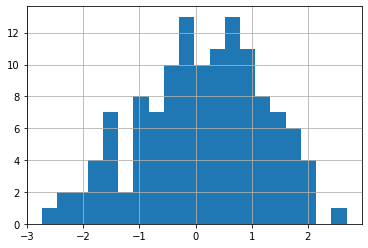

In [95]:
#plotting residuals to visually inspect for normality
residuals.hist(bins=20)
plt.show()

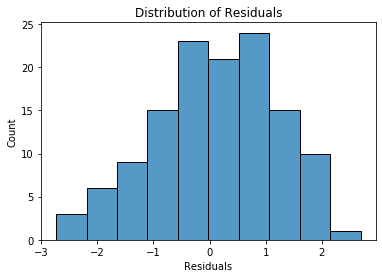

In [100]:
ax = sns.histplot(x=residuals)
ax.set_title('Distribution of Residuals')
ax.set_xlabel('Residuals');
plt.savefig('images/dist_residuals.png')

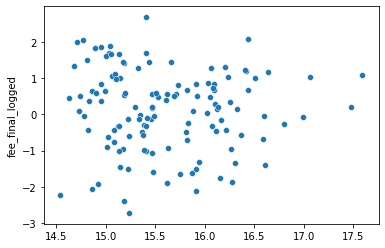

In [96]:
#plotting residuals against predicted values to assess hetero/homoscedasticity
sns.scatterplot(y=residuals, x=y_hat_test)

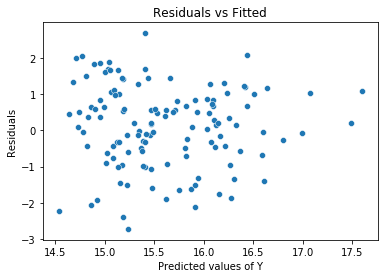

In [103]:
ax = sns.scatterplot(y=residuals, x=y_hat_test)
ax.set_title('Residuals vs Fitted')
ax.set_xlabel('Predicted values of Y');
ax.set_ylabel('Residuals')
plt.savefig('images/residuals_vs_fitted.png')